# Step 1: Drug Formulary PDF Ingestion Pipeline - Extraction, Cleaning, and CSV Export

This notebook automates the ingestion and processing of drug formulary PDFs (e.g., insurance plans, healthcare benefits) into structured data. It begins by importing dependencies and listing input files, then uses the `camelot-py` library to extract tabular data from PDFs, focusing on lattice-based table detection with tuned parameters. Extracted tables undergo header normalization to standardize column names, followed by merging fragmented tables into a unified dataset. The data is cleaned to remove inconsistent whitespace, and drug tier information (cost structures) is explicitly parsed. Finally, the processed data is exported to `out1.csv`, creating a reusable structured dataset from unstructured PDF formulary documents.

## Import Libraries and List Input Files
Imports necessary libraries and lists all input files in the directory.

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kp-formularies/kaiser-permanente-insurance-company-ppo-and-out-of-area-indemnity-formulary-ca-en.pdf
/kaggle/input/kp-formularies/postal-service-health-benefits-drug-formulary-scal-en.pdf
/kaggle/input/kp-formularies/commercial-marketplace-formulary-ca-en.pdf
/kaggle/input/kp-formularies/commercial-hmo-formulary-scal-en.pdf
/kaggle/input/kp-formularies/deductible-epo-self-funded-plans-formulary-ca-en.pdf
/kaggle/input/kp-formularies/kaiser-permanente-insurance-company-pos-formulary-ca-en.pdf


## Install Camelot Library
Installs the `camelot-py` package for PDF table extraction.

In [2]:
!pip install -q camelot-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.3 MB/s eta 0:00:00


## Extract Tables from PDF
Uses Camelot to extract all tables from the specified PDF with tuned parameters.

In [3]:
import camelot
tables = camelot.read_pdf(
    "/kaggle/input/kp-formularies/postal-service-health-benefits-drug-formulary-scal-en.pdf", 
    pages="all", 
    parallel=True,

    # tuned via visual inspection (see below)
    flavor="lattice", # uses lines to detect tables
    split_text=True, # in case there is cell overflow
    copy_text=["h",], # overflow to the right (horizontally)
    line_scale=50, # adjust line detection sensitivity
)
tables

/usr/local/lib/python3.10/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


<TableList n=41>

## Visual Debugging Examples
Examples on how to debug and tune Camelot's detection mechanism

We will use the last table in the formulary as an example

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 12)
i_tbl = -1 # last table

**line** shows the lines detected that is relevant to the table in question

I think this is the most useful one: it shows why there are mistakes in the last table
  
*line-like objects (like the small letter L) can confuse the library*

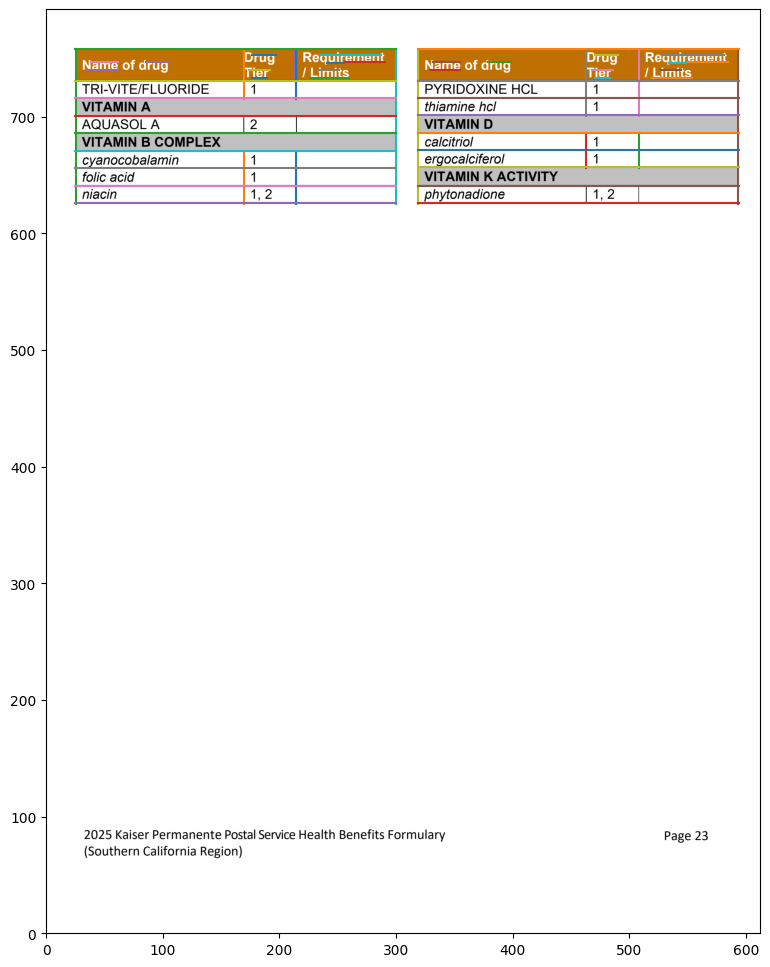

In [5]:
camelot.plot(tables[i_tbl], kind='line').show() 

**grid** shows each cell's boundary

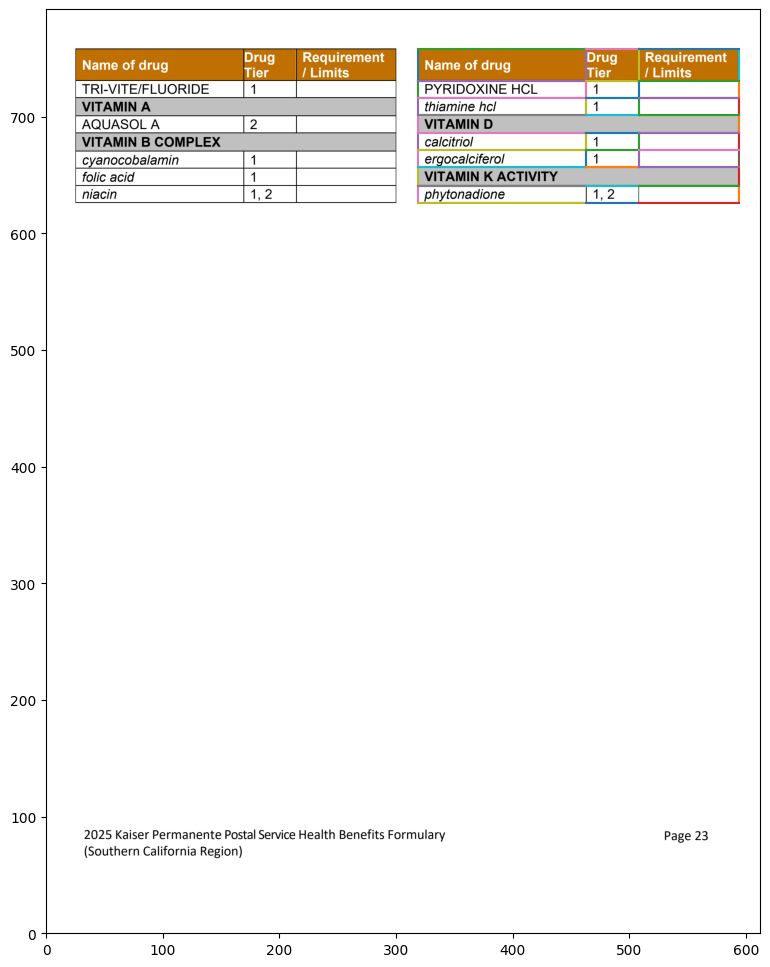

In [6]:
camelot.plot(tables[i_tbl], kind='grid').show()

**joint** shows each cell's corners

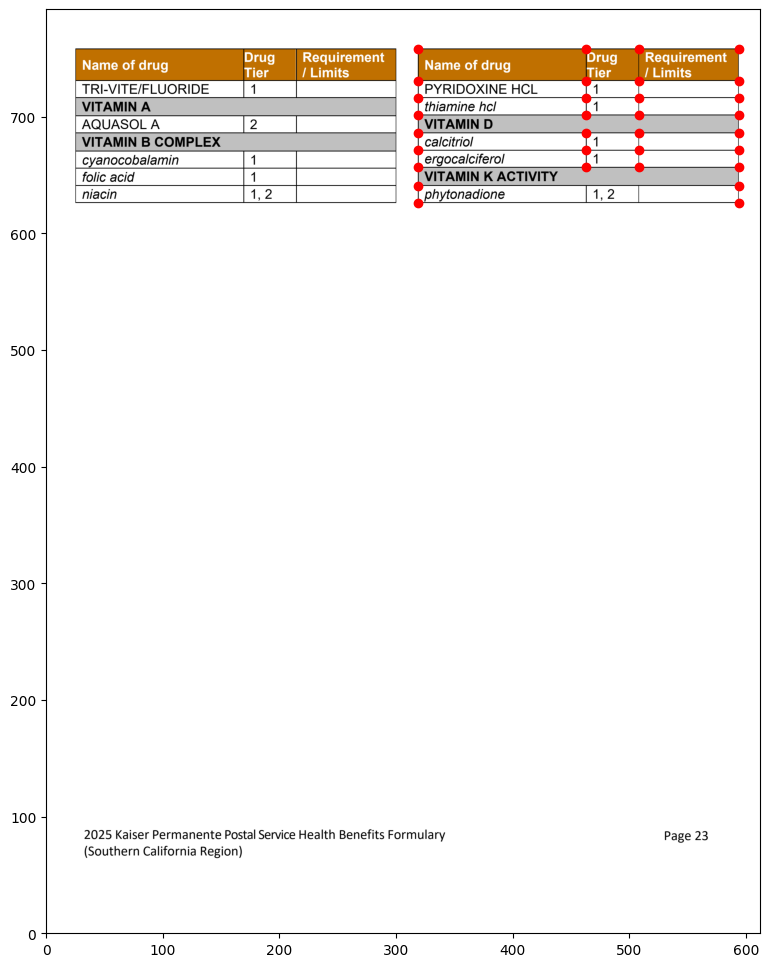

In [7]:
camelot.plot(tables[i_tbl], kind='joint').show()

**contour** shows the table boundary

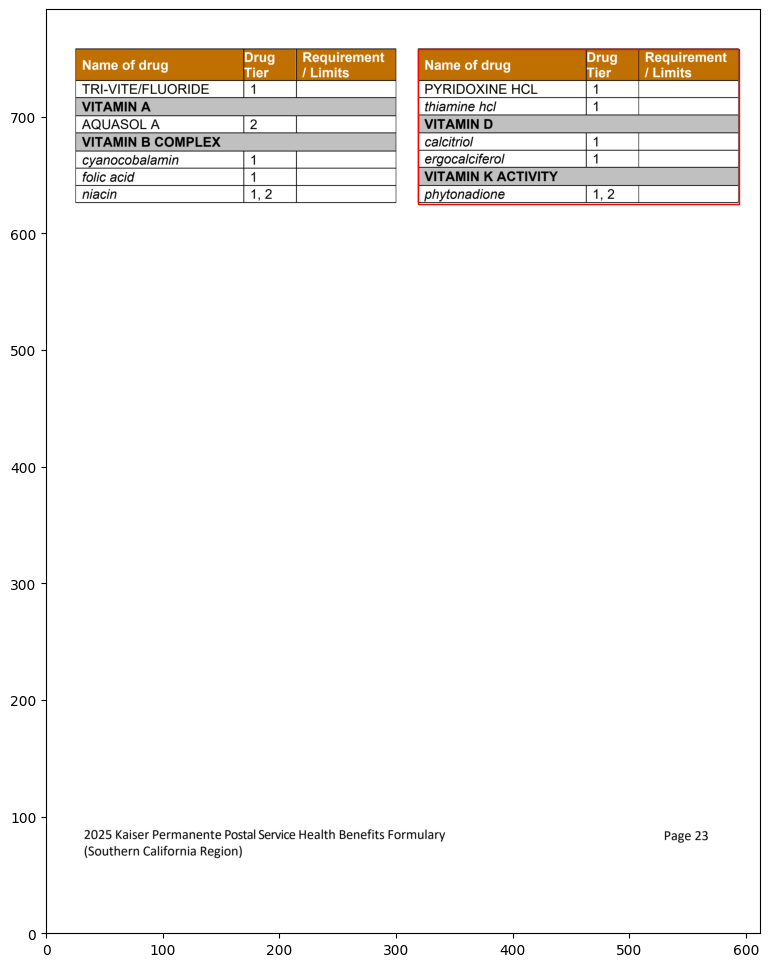

In [8]:
camelot.plot(tables[i_tbl], kind='contour').show()

## Define Header Normalization Function
Creates a function to standardize DataFrame headers by cleaning and formatting column names.

In [9]:
import re

def handle_headers(data):
    data = data.copy()
    if type(data.columns) == pd.core.indexes.range.RangeIndex:
        headers = data.iloc[0]
        data.columns = ["_".join([chunk for chunk in re.split("[^a-z]", col.lower()) if len(chunk) > 0]) 
                        for col in headers.values]
        data = data.drop(0)
    return data

handle_headers(tables[1].df).head()

,n_ame_of_drug,drug_tier,requirement_limits
1,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS
2,ANTHELMINTICS,ANTHELMINTICS,ANTHELMINTICS
3,albendazole,1,
4,ivermectin,1,
5,ANTIBACTERIALS,ANTIBACTERIALS,ANTIBACTERIALS


## Extract Drug Tier Information Table
Processes and displays the first table containing drug tier cost details.

In [10]:
tier_table = handle_headers(tables[0].df)
tier_table.to_csv("tiers.csv")
tier_table

,drug_tier,type,high_option,standard_option
1,Tier 1,Generic drugs,$10,$15
2,Tier 2,Preferred brand-name drugs,$40,$50
3,Tier 3,Non-preferred brand-name drugs,$40,$50
4,Tier 4,Specialty drugs,$100,$150


## Determine Most Frequent Column Headers
Identifies common column headers across all extracted tables for consistency.

In [11]:
cols = pd.DataFrame([handle_headers(table.df).columns.tolist() for table in tables[1:]])
cols

,0,1,2
0,n_ame_of_drug,drug_tier,requirement_limits
1,name_of_drug,drug_tier,requirement_limits
2,name_of_drug,drug_tier,requirement_limits
3,name_of_drug,drug_tier,requirement_limits
4,name_of_drug,drug_tier,requirement_limits
5,name_of_drug,drug_tier,requirement_limits
6,name_of_drug,drug_tier,requirement_limits
7,name_of_drug,drug_tier,requirement_limits
8,name_of_drug,drug_tier,requirement_limits
9,name_of_drug,drug_tier,requirement_limits


In [12]:
headers = cols.mode().values[0].tolist() # most common column
headers

['name_of_drug', 'drug_tier', 'requirement_limits']

## Merge All Tables into Unified DataFrame
Standardizes headers and combines all extracted tables into a single dataset.

In [13]:
def force_headers(df, headers):
    df = handle_headers(df)
    df.columns = headers
    return df

data = pd.concat([force_headers(table.df, headers) for table in tables[1:]], ignore_index=True)
data

,name_of_drug,drug_tier,requirement_limits
0,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS
1,ANTHELMINTICS,ANTHELMINTICS,ANTHELMINTICS
2,albendazole,1,
3,ivermectin,1,
4,ANTIBACTERIALS,ANTIBACTERIALS,ANTIBACTERIALS
...,...,...,...
1411,VITAMIN D,VITAMIN D,VITAMIN D
1412,calcitriol,1,
1413,ergocalciferol,1,
1414,VITAMIN K ACTIVITY,VITAMIN K ACTIVITY,VITAMIN K ACTIVITY


## Clean Whitespace in DataFrame Entries
Normalizes extra spaces in all DataFrame cells for uniformity.

In [14]:
def normalize_spaces(s):
    return " ".join(re.split("\s+", s))

data = data.map(normalize_spaces)
data

,name_of_drug,drug_tier,requirement_limits
0,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS,ANTI-INFECTIVE AGENTS
1,ANTHELMINTICS,ANTHELMINTICS,ANTHELMINTICS
2,albendazole,1,
3,ivermectin,1,
4,ANTIBACTERIALS,ANTIBACTERIALS,ANTIBACTERIALS
...,...,...,...
1411,VITAMIN D,VITAMIN D,VITAMIN D
1412,calcitriol,1,
1413,ergocalciferol,1,
1414,VITAMIN K ACTIVITY,VITAMIN K ACTIVITY,VITAMIN K ACTIVITY


## Export Processed Data to CSV
Saves the cleaned and merged DataFrame to a CSV file named `out1.csv` for further processing.

In [15]:
data.to_csv("out1.csv")